# Foundations of Reinforcement Learning 2021 - Assignment 3

In this assignment, you will implement the REINFORCE and A2C algorithms shown in the lectures for solving reinforcement learning tasks. The implementations will be tested first on a simplistic toy RL problem (similar to grid world) and then on a more non-trivial robotic control task on the [OpenAI Gym](https://gym.openai.com/), i.e.,
- a 7x7 deterministic grid world,
- the [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment.

You will get hands-on experience in implementing and testing reinforcement learning algorithms in practice, as well as using neural networks for function approximation.
You will also get the chance to see how your algorithms learn over many iterations and compare the two algorithms, as well as exploration-exploitation considerations.

We have implemented a skeleton notebook and the places you need to fill in is marked with `TODO` comments or clearly stated in the context. 
To get started, prepare your Python environment following the instructions in `Readme`.

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

import matplotlib.pyplot as plt
from matplotlib.table import Table

import time
import numpy as np

import gym
from gym import wrappers

## Part 1: Gridworld with REINFORCE (50 points)

Firstly, you will implement the algorithms in the GridWorld environment. The agent starts from the center, and the four actions left, right, up and down move the agent in the appropriate directions deterministically. The corner states are terminal and have the corresponding rewards.

**In this part, you should only use `numpy` operations (i.e., no automated differentiation with PyTorch).**

### The Gridworld Environment

We already provide a basic implementation of the grid world environment which you will use,
as well as the constants `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`.
You do not need to modify the class `GridWorld`.

In [56]:
ACTION_LEFT = 0
ACTION_RIGHT = 1
ACTION_UP = 2
ACTION_DOWN = 3

def clip(x, a, b):
    if x < a:
        return a
    if x > b:
        return b
    
    return x

class GridWorld:
    
    def __init__(self, size=3):
        self.size = size
        self.state = [0,0]
        self.actions = [ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN]
        
    def reset_world(self):
        self.state = [0,0]
    
    def is_terminal(self):
        return abs(self.state[0]) == self.size and abs(self.state[1]) == self.size
    
    def get_current_reward(self):
        if self.state == [self.size, self.size] or \
           self.state == [-self.size, -self.size]:
            return -1
        elif self.state == [-self.size, self.size] or \
             self.state == [self.size, -self.size]:
            return +1
        else:
            return 0
        
    def list_actions(self):
        return self.actions
    
    def step(self, action):
        if action not in self.actions:
            raise NotImplementedError("Action not defined")
            
        if self.is_terminal():
            raise NotImplementedError("Episode terminated! Call reset_world first.")

        if action == ACTION_LEFT:
            self.state[0] = clip(self.state[0]-1, -self.size, self.size)
            
        elif action == ACTION_RIGHT:
            self.state[0] = clip(self.state[0]+1, -self.size, self.size)
            
        elif action == ACTION_UP:
            self.state[1] = clip(self.state[1]+1, -self.size, self.size)
            
        elif action == ACTION_DOWN:
            self.state[1] = clip(self.state[1]-1, -self.size, self.size)
        
    def get_coordinates(self):
        s = np.array(self.state)
        s[0] = s[0] + self.size
        s[1] = self.size - s[1]
        
        return s
    
    def get_state(self):
        return self.get_coordinates()[0] + \
               self.get_coordinates()[1] * (self.size * 2 + 1)
    
    def render_state(self):
        N = self.size
        x = self.state[0]
        y = self.state[1]

        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()

        tb = Table(ax, bbox=[0,0, 1, 1])

        row_labels = np.arange(2 * N + 1)
        col_labels = np.arange(2 * N + 1)
        width, height = .5, .5

        values = np.zeros((N*2+1, N*2+1))
        values[0,0] = values[-1, -1] = 1
        values[-1,0] = values[0, -1] = -1

        cell_colors = ('white', 'whitesmoke')
        font_colors = ('black', 'white')

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            if cell_val !=  0.:
                text = "%.1f" % cell_val
                if cell_val > 0:
                    c = "lightblue"
                else:
                    c = "lightcoral"
            elif row_idx == N and col_idx == N:
                text = "start"
                c = "antiquewhite"
            else:
                text = ""
                c = cell_colors[idx]

            tb.add_cell(row_idx, col_idx, width, height,
                        text=text,
                        loc='center',
                        facecolor=c)

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[idx])

        pos = plt.Circle((0.5 + 1/(2 * N + 1) * x, 0.5 + 1/(2 * N + 1) * y + .04), 0.01, color='black')
        ax.add_patch(pos)
        ax.add_table(tb)

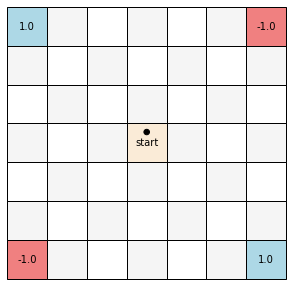

In [57]:
# You can plot the environment with render_state()
GridWorld().render_state()

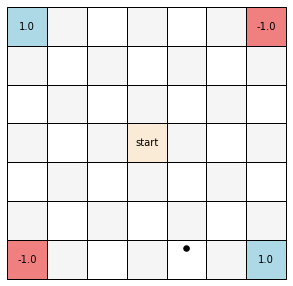

In [58]:
# The state after the agent takes actions
world = GridWorld()
world.reset_world()
world.step(ACTION_RIGHT)
world.step(ACTION_DOWN)
world.step(ACTION_DOWN)
world.step(ACTION_DOWN)
world.render_state()

In [59]:
# cells/states are numbered from 0 to 48, left to right, top to bottom
world.get_state()

46

In [60]:
# for convenience, cells are given coordinates left to right, top to bottom
world.get_coordinates()

array([4, 6])

### Direct Parameterisation

In this task, we will parametrise our policy using a direct softmax parametrisation.
$$
\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_a {\exp{\theta^\top \phi_{s,a}}}}
$$
We will assume that the vectors $\phi_{s,a} \in \mathbb{R}^{|\mathcal{S}||\mathcal{A}|}$ are encoded as standard unit basis vectors (i.e., one-hot encoding).
First, we will create an appropriate encoding function for the states in the gridworld.

For consistency, we assume the actions are mapped to integers with `ACTION_LEFT=0, ACTION_RIGHT=1, ACTION_UP=2, ACTION_DOWN=3`, and the cell states are given values from 0 to 48, starting from left to right, from the top row to the bottom row. 
Note that `GridWorld.get_state()` implements the correct order on grid cells.
$\phi_{s,a}$ is assumed to be the unit vector with only entry at position $4\times s + a$ equal to 1.

<b style="color:red"> Question 1.1 (5 points): </b> Create a function `get_features_onehot` that encodes each $\phi_{s,a}$ with a one hot encoded vector in $\mathbb{R}^{|\mathcal{S}||\mathcal{A}|} = \mathbb{R}^{196}$ as a numpy vector.

In [61]:
def get_features_onehot(state:int, action:int):
    """Given the tuple (x,y) indicating the coordinates on the grid world, return one hot encoded features
    
    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """
    
    ## TODO: you should implement this function for question 1.1
    features_onehot = np.zeros(196)
    features_onehot[4 * state + action] = 1
    return features_onehot

<b style="color:red"> Question 1.2 (5 points): </b> Implement an initialisation for the parameters $\theta \in \mathbb{R}^{196}$ as a numpy vector that you think is appropriate for efficient exploration.

In [62]:
def get_initial_parameters():
    """Returns vector of size 196 of initial parameters theta"""
    
    ## TODO: you should implement this function for question 1.2
    return np.zeros(196)

<b style="color:red"> Question 1.3 (5 points): </b> 
Calculate the partial derivatives $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$.
First, write down the analytic formula for the derivative using latex in the cell below (you do not need to show your computation steps).
Then, using your expression fill in `direct_parameterisation_derivative`, that will return the vector $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$ given a value of $\theta$ and action-state pair $a,s$.

**Hint:** For the analytic part, you may write down the formula for $\frac{\partial \pi_\theta(a|s)}{\partial \theta_{a',s'}}$, i.e., the partial derivative with respect to the entry of $\theta$ corresponding to any action-state pair $a', s'$.

**Hint:** The function `direct_parameterisation_derivative` should return a vector of size $4 |S| = 4 \times 7^2=196$, since you have 4 actions and $7^2$ states.

**Hint:** Only 4 entries of $\frac{\partial \pi_\theta(a|s)}{\partial \theta} \in \mathbb{R}^{196}$ should be nonzero for fixed $a,s$.

*enter your formula here using latex*

In [63]:
def direct_parameterisation_gradient(action: int, state: int, theta):
    """Returns the partial derivatives of the policy with respect to theta
    
    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """
    
    grad = np.zeros(196)
    
    ## TODO: enter you implementation here
    def pi_theta(state, action):
        deno = 0
        for a in range(4):
            deno += np.exp(np.sum(theta * get_features_onehot(state, a)))
        return np.exp(np.sum(theta * get_features_onehot(state, action))) / deno
    
    agg = 0
    for a in range(4):
        agg += pi_theta(state, a) * get_features_onehot(state, a)
    grad = pi_theta(state, action) * (get_features_onehot(state, action) - agg)
    return grad

The code below helps you check if your derivative implementation is correct.
In case your implementation works, the code should print success.
You should not modify the cell below.

In [64]:
## checks the code above
torch.manual_seed(0)
success = True
N = 10
err = 0.

for i in range(N):
    theta = torch.rand((4*49))
    theta.requires_grad = True
    
    for state in range(49):
        for action in range(4):
            by_state = torch.exp(theta).reshape(49,4)
            out_prob = by_state / by_state.sum(-1, keepdim=True)
            out_prob.reshape(-1)[action + state*4].backward()

            answer = direct_parameterisation_gradient(action, state, theta.detach().numpy())
            
            err += np.abs(answer - theta.grad.numpy()).sum()
            
            if not np.allclose(answer, theta.grad.numpy()):
                success = False
                
            theta.grad.zero_()
    
if success:
    print(f"Success: errors within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
else:
    print(f"Fail: errors not within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
    
del theta, by_state, out_prob, answer

Success: errors within tolerance. Mean abs. error: 2.1750211723220673e-08


### REINFORCE Implementation

<b style="color:red"> Question 1.4 (5 points): </b>
In the lectures, you have been introduced to the REINFORCE algorithm.
Explain in two sentences what the regular REINFORCE objective aims to optimise and how this is achieved only using samples and no prior information on the MDP dynamics.

*REINFORCE aims to optimize the expected episodic reward collected by the policy we are trying to optimize over.*

*By using the logarithm trick, we split out the initial state distribution and the transition probabilities of the MDP which do not depend on the policy parameter $\theta$. Taking a derivative of the logarithm of the trajectory probability with respect to $\theta$ eliminates such prior information on MDP dynamics.*

<b style="color:red"> Question 1.5 (10 points): </b>
Using your functions implemented in questions 1.1, 1.2, 1.3, fill in the `ReinforceLearner` class.
You can use the already implemented methods of the `GridWorld` class:
- `reset_world`: reset the world to starting state
- `is_terminal`: is the current state terminal
- `get_current_reward`: reward of the current state
- `step`: given an action among `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`, takes a step in the simulation
- `get_state`: get current state, as an integer from 0 to 48
- `get_coordinates`: get current coordinates in table as a tuple (x,y)
- `render_state`: render the current state of the grid world, useful for debugging

**Hint:** You do not need to implement an exploration strategy with the appropriate intialisation, so only vanilla policy gradient steps should be sufficient for convergence with an appropriate learning rate.

In [65]:
class ReinforceLearner:

    def __init__(self, learning_rate, gamma):
        """Intialisation code"""
        
        self.world = GridWorld()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.theta = get_initial_parameters()
        
        ## TODO: you may use other variables or inputs as you hyper-parameters
        
    def get_action_prob(self, state:int):
        """Given the state, return the probability of taking each of the 4 actions"""
        
        ## TODO: your implementation
        action_prob = np.zeros(4)
        deno = 0
        for a in range(4):
            deno += np.exp(np.sum(self.theta * get_features_onehot(state, a)))
        
        for a in range(4):
            action_prob[a] = np.exp(np.sum(self.theta * get_features_onehot(state, a))) / deno
        return action_prob
    
    def train(self, n_updates:int, n_trajectories:int):
        """Run the training procedure for n_updates steps
        
        n_trajectories: how many trajectories should be sampled each REINFORCE step
        n_updates: how many parameters updates to make (each parameter update would sample n_trajectories)"""
        
        rewards = []
        for episode in range(n_updates):
            rewards.append(self.reinforce_step(n_trajectories))
                
        return rewards
        
    def reinforce_step(self, n_trajectories:int):
        """Run a single gradient step for REINFORCE using n_trajectories many trajectories for estimation.
        
        Also return the average reward observed"""
        
        ## TODO: your implementation       
        rew_buf = np.zeros((n_trajectories, 1))
        score_buf = np.zeros((n_trajectories, 196))
        for traj in range(n_trajectories):
            self.world.reset_world()
            t = 0
            while not self.world.is_terminal():
                s = self.world.get_state()
                action_prob = self.get_action_prob(s)
                a = np.random.choice(self.world.actions, p=action_prob)
                phi_exp = 0
                for action in self.world.actions:
                    phi_exp += get_features_onehot(s, action) * action_prob[action]
                score = get_features_onehot(s, a) - phi_exp
                score_buf[traj] += score
                self.world.step(a)
                rew_buf[traj] += self.gamma ** t * self.world.get_current_reward()
                t += 1
            
        rew_mean = np.mean(rew_buf, axis=0)
        grad = np.mean(score_buf * rew_buf, axis=0)
        self.theta += self.learning_rate * grad
        return rew_mean
        
    def evaluate(self):
        """Evaluate current algorithm for a single episode and return.
        
        You should 
        (a) Print the total reward from the episode.
        (b) Visualise the whole state history. (Hint: You can use multiple calls to GridWorld.render_state())"""
        
        ## TODO: your implementation
        self.world.reset_world()
        t = 0
        ret = 0
        while not self.world.is_terminal():
            s = self.world.get_state()
            action_prob = self.get_action_prob(s)
            a = np.random.choice(self.world.actions, p=action_prob)
            self.world.step(a)
            self.world.render_state()
            ret += self.gamma ** t * self.world.get_current_reward()
            t += 1
        print("Total reward of the episode is {}".format(ret))

### Evaluation

<b style="color:red"> Question 1.6 (10 points): </b> Run the above code until convergence, and evaluate your strategy at the end.
Plot the average reward observed per epoch during training.
You may need to tune your hyper-parameters.

Total reward of the episode is 1


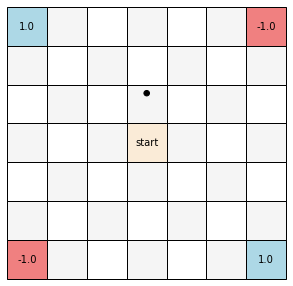

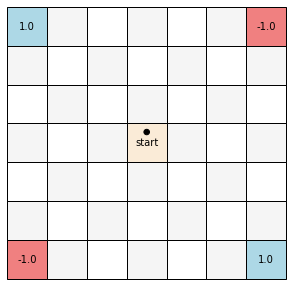

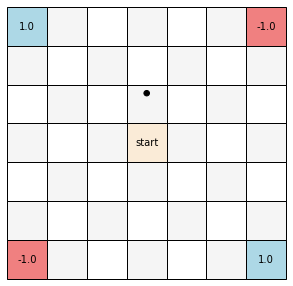

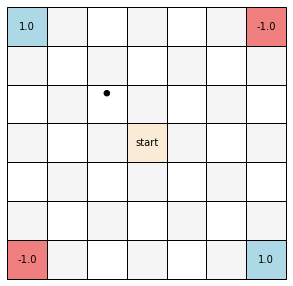

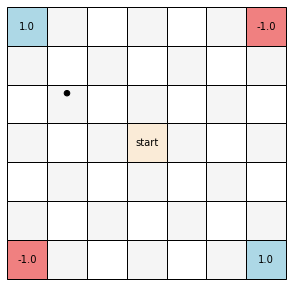

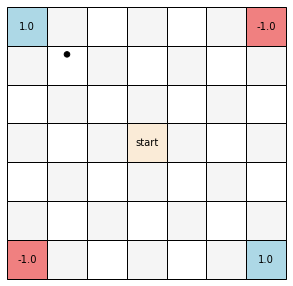

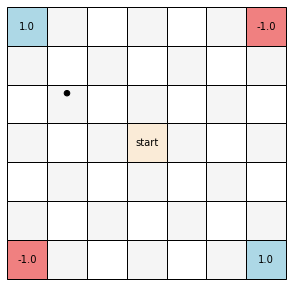

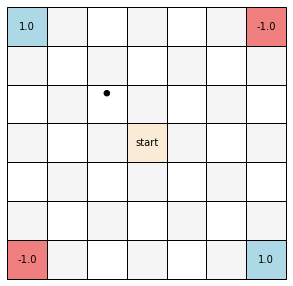

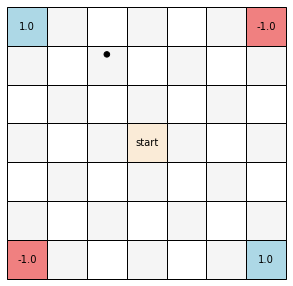

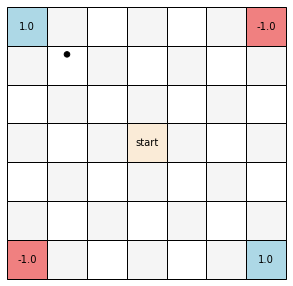

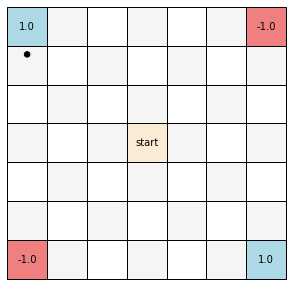

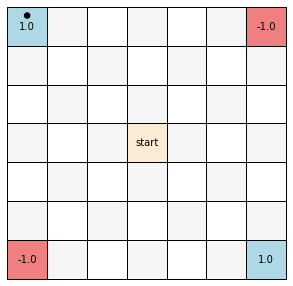

In [66]:
## TODO: your implementation for 1.5, you can modify

learner = ReinforceLearner(learning_rate=0.5, gamma=1)
rewards = learner.train(n_updates=100, n_trajectories=100)
learner.evaluate()

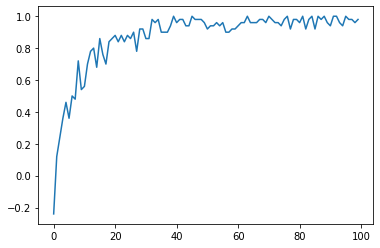

In [67]:
## TODO: plot your rewards for 1.5, you can modify

plt.figure()
plt.plot(rewards)

### Additional Questions

<b style="color:red"> Question 1.7 (5 points): </b>
The code above for REINFORCE does not implement an explicit exploration strategy.
Explain how the exploration-exploitation trade-off was circumvented by your choice of parameters intialisation in two sentences, and how this approach could fail for some other initialisation strategies.

*By initializing all entries of $\theta$ to be zero, we get a uniform policy, where it is equally possible to sample actions towards any of the four directions at each state. Such a stochastic policy would encourage the agent to explore the state-action space in paricular during its first visit at one state.*

*If we initialize entries of $\theta$ arbitrarily, it might happen that at certain state, the action corresponding to a relatively small value of entry of $\theta$ will never be sampled by the actor in finite steps. In this case, this specific state-action pair will never be explored and the corresponding entry of $\theta$ will never be updated.*

<b style="color:red"> Question 1.8 (5 points): </b> In 2 sentences explain the shortcomings of the direct parametrisation.

*When dealing with large state or action spaces or with continuous problems, a direct parameterization will cause memory explosion to store parameters for each of the state-action pairs. It is also slow to learn each entry individually as opposed to learn parameters of a function or neural network that accommodates all states, especially in the case where we need to generalize to states with rare observations or new states.*

## Part 2: CartPole with A2C (50 points)

In this second part, you will implement a neural network based agent trained with A2C on a more involved robotics task.
Unlike the first part, you will use automated gradients via PyTorch.

### OpenGym Intro

First, we provide a quick introduction to OpenAI Gym.
This part does not include questions, as is intended to introduce basic concepts of the Gym library.

We will use the environment [CartPole](https://gym.openai.com/envs/CartPole-v1/) in this assignment.
You can find detailed explanations and a visualization in the link we provided.
In the environment, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The system is controlled by applying a force of +1 or -1 to the cart. 
The pendulum starts upright, and the goal is to prevent it from falling over. 
A reward of +1 is provided for every timestep that the pole remains upright. 
The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 
The following cells show how to interact with this environment.

In [68]:
# use make() to create an environment for CartPole
env = gym.make('CartPole-v1')

There are two discrete actions available, i.e. applying a force of either +1 or -1.

In [69]:
env.action_space

Discrete(2)

The state space contains four real numbers in given intervals. It is explained by the predefined `Box` class. The first entry indicates the lower bound and the second entry shows the upper bound. For example, for CartPole, the first value of the state is within (-4.8,4.8), and the second is in (-3.40e38, 3.40e38), etc.

In [70]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Here is an example of playing a random policy in this environment.

In [71]:
max_len = 100 # maximal length of one episode

# use reset() to reinitialize a new episode and get an initial state
state = env.reset()

for t in range(max_len):
    # use render() to display the current state
    env.render()    
    
    # randomly sample an action in the action space
    action = env.action_space.sample()
    
    # use step() to interact with the gym environment
    # given current state and action, return next state and reward
    # is_terminal indicates whether a terminal state is reached, debug_info contains some debug information
    next_state, reward, is_terminal, debug_info = env.step(action)
    
    if is_terminal:
        print("Episode terminated after {} steps".format(t + 1))
        break

# remember this when you finish
env.close()

Episode terminated after 18 steps


### PyTorch Intro

We also introduce basic functionality for PyTorch.
PyTorch is a widely used automatic differentiation library, which is very useful for training neural networks.
This part is also for guidance and does not include questions.
While we do introduce the basics of PyTorch, you are encouraged to explore more about the library following the official [tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) in case you haven't used it before.

PyTorch is built on top of the class `torch.Tensor`, which implements many operations on vectors, matrices and higher dimensional tensors.
The functionality of operations on torch tensors closely mirrors the operations from the `numpy` package.

In [72]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [73]:
a_matrix = [[1., 2.],[3., 4.]]
torch.tensor(a_matrix)

tensor([[1., 2.],
        [3., 4.]])

In [74]:
torch.matmul(torch.tensor(a_matrix), 
             torch.tensor([4., 5.]))

tensor([14., 32.])

What makes torch special is that it implements automated differentiation by tracking the operation history on tensors.
Namely, if a `torch.Tensor` has the propery `.requires_grad` set to `True`, torch will automatically track operations made on that tensor.
A final `.backward()` call to a computation result will compute partial derivatives of the variable with respect to all tensors in the tracked computational graph.
This is particularly useful for tracking derivatives with respect to a loss function, to enable simple gradient descent.

In [75]:
# example from https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

tensor(0.1459, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [76]:
# differentiate with respect to loss
loss.backward()
# the computed partial derivatives of w
w.grad

tensor([[0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001]])

To prevent tracking history, you can also wrap a piece of code in`with torch.no_grad():`. 
This can be particularly helpful when evaluating a model on new data, when training (and hence differentiation) is not required.

For more advanced modelling (as will be required by this exercise), it is usually useful to implement classes as children of `nn.Module`.
These implement the function `forward`, which returns the output of the forward pass of a model given inputs.
Modules have `nn.Parameter`, which will be the trainable parameters of the models.
Most useful sub-modules are already provided by the torch package: see for instance `nn.Linear`.

Finally, torch implements many standard optimizers: for instance `torch.optim.SGD`, `torch.optim.Adam`.
These are typically used to automatically take care of training once partial derivatives are computed.

### Advantage Actor-Critic (A2C)

A more stable alternative to vanilla policy gradients via REINFORCE is the so-called A2C algorithm.
First, you should familiarise yourself with the A2C algorithm reading the original [paper](https://arxiv.org/pdf/1602.01783.pdf).

<b style="color:red"> Question 2.1 (10 points): </b> Explain in a few sentences each, 

1. how the A2C algorithm addresses the shortcomings of vanilla policy gradient methods,
2. the difference between A2C and A3C,
3. why the A3C algorithm could be expected to perform even better than A2C.

*1. Vanilla policy gradient methods (REINFORCE) uses an unbiased estimate of the gradient of the expected return to update the policy parameterization. This estimate in general has a high variance due to stochasticity in different trajectories. A2C algorithm reduces the variance of this estimate while keeping it unbiased by using an estimate of the advantage function, where a learned value function estimate is subtracted as a baseline.*

*2. The key difference from A2C is the asynchronous implementation. A3C consists of multiple independent agents with their own thread-specific parameters, who interact with a different copy of the environment in parallel. The agents are trained in parallel and update periodically a global network, which holds shared parameters. The updates are not happening simultaneously. After each update, the agents resets their parameters to those of the global network and continue their independent exploration and training for $n$ steps until they update themselves again.*

*3. A3C achieves substantial speedups from using multiple worker threads as opposed to A2C. This confirms that A3C scales well with the number of parallel workers, making efficient use of resources and increasing the diversity of training data. In addition, A3C is also very robust to the choice of learning rate and random initialization.*

### Neural Network Parametrization

We will use neural networks to parameterize both the value function and the policy.
The `Actor_Net` defines the policy $\pi_\theta(a|s)$. Given state $s$ as input, it will output a distribution over the action space. 
The `Critic_Net` defines the approximation to the value function, which could be denoted $\hat{V}_w(s)$. 

You can play with different network architectures and the [activation](https://pytorch.org/docs/stable/nn.html) functions.
Note that the `Actor_Net` should produce a probability distribution over the action space.

<b style="color:red"> Question 2.2 (10 points): </b>
Design your own neural networks in the code block below.

In [77]:
class Actor_Net(nn.Module):
    def __init__(self, num_state, num_action):
        super(Actor_Net, self).__init__()
        
        # TODO: you should implement your model here
        # see torch.nn.Sequential, for a hint
        hidden_sizes = [64, 64]
        sizes = [num_state] + list(hidden_sizes) + [num_action]
        activation = nn.Tanh
        output_activation = nn.Softmax
        layers = []
        for j in range(len(sizes)-1):
            act = activation if j < len(sizes)-2 else output_activation
            layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
        self.model = nn.Sequential(*layers)
       
    # return a probability distribution over the action space
    def forward(self, state):
        return self.model(state)


class Critic_Net(nn.Module):
    def __init__(self, num_state):
        super(Critic_Net, self).__init__()
        
        # TODO: you should implement your model here
        # see torch.nn.Sequential, for a hint
        hidden_sizes = [64, 64]
        sizes = [num_state] + list(hidden_sizes) + [1]
        activation = nn.ReLU
        output_activation = nn.Identity
        layers = []
        for j in range(len(sizes)-1):
            act = activation if j < len(sizes)-2 else output_activation
            layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
        self.model = nn.Sequential(*layers) 
       
    # return a single value
    def forward(self, state):
        return self.model(state)

### Learning in a Continuous Environment

We train both the actor and critic nets by interacting with the environment.
You should fill in the marked places below to implement the A2C training process.

<b style="color:red"> Question 2.3 (30 points): </b>
Fill in the code below (the parts marked `TODO`) to implement A2C in the CartPole environment.
You should play with your hyper-parameters as well, to enable efficient learning.
You may play with different learning rates and optimizers.
For different optimizers in PyTorch, see [here](https://pytorch.org/docs/stable/optim.html).

In [78]:
# initiate both nets
actor = Actor_Net(env.observation_space.shape[0], 
                  env.action_space.n)
critic = Critic_Net(env.observation_space.shape[0])

# set gamma and learning rates
gamma = 0.99
actor_lr = 1e-3
critic_lr = 1e-3

# TODO: also play with different optimizers
actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

In [79]:
start_time = time.time()
max_iter = 1000
max_episode_len = 1000
total_reward = []

for num_iter in range(max_iter):
    # at each iteration, we roll out an episode using current policy until it reach termination state or the maximum length
    reward = []
    value_buf = []
    log_p_buf = []
    
    s = env.reset()
    for t in range(max_episode_len):
        # given current state, the actor outputs two values as probability for each action
        state = torch.tensor(s, dtype=torch.float).view(1, -1)
        prob = actor(state)
        # create the distribution as current policy
        pi = Categorical(prob)
        # sample one action from this policy
        a = pi.sample()
        
        # interact with the environment
        s, r, is_terminal, _ = env.step(a.item())      
        reward.append(r)
        
        # TODO: what information will be used
        # hints: outputs of the actor and critic nets
        value = critic(state)
        value_buf.append(value)
        log_p = pi.log_prob(a)
        log_p_buf.append(log_p)
        
        if is_terminal:
            break
            
    # store total_reward
    total_reward.append(sum(reward))
    
    # TODO: use the episode to update parameters
    # for the actor, you can use policy gradient method (with baseline), what is the loss
    # for the critic, you can use Monte-Carlo, TD(0), TD(\lambda), what is the loss
    
    returns = torch.zeros(len(reward) + 1)
    advantage = torch.zeros(len(reward))
    value = torch.cat(value_buf)
    log_p = torch.cat(log_p_buf)
    
    
    for t in reversed(range(len(reward))):
        returns[t] = reward[t] + gamma * returns[t + 1]
        advantage[t] = returns[t] - value[t]
    
    
    # TODO: add your implementation here
    actor_loss = -(log_p * advantage.detach()).mean()
    critic_loss = (torch.square(advantage)).mean()
    
    actor_opt.zero_grad()
    critic_opt.zero_grad()
    
    actor_loss.backward()
    critic_loss.backward()
    
    actor_opt.step()
    critic_opt.step()

env.close()
print('Training time: {:.2f}s'.format(time.time() - start_time))

Training time: 307.03s


**Useful hints:**

1. See [here](https://pytorch.org/docs/stable/distributions.html) for distributions in PyTorch. You may find the function `log_prob()` useful. You can easily compute $\log\pi(a|s)$ and its gradient using the function.

2. To optimize a model in PyTorch, you first define the loss function, then call the corresponding optimizer and perform backpropagation. For example, to optimize over the value function approximation, first let $\text{loss}=\|V_w-V^\pi\|^2$ and then call `loss.backward()` to compute the gradient.

3. You may find the function `detach()` defined in PyTorch useful if you need to call `backward()` multiple times on the same variables without storing the computational graph every time.

4. Maximizing $f(x)$ is equivalent to minimizing $-f(x)$. The default optimizers in PyTorch perform minimization.

5. You may find the classes `torch.nn.Softmax`, `torch.nn.ReLU`, `torch.nn.Tanh` useful when implementing a neural network architecture.

6. You may experiment with epsilon greedy and possibly different decay rates for the epsilon parameter.

**Analysing your results:**

You can run the codes below to test your algorithm.
These will help you understand if your algorithm is working, and will help us grade your implementation.

In [80]:
# the results will be saved as videos, but make sure you have ffmpeg installed.
# on mac, you can do this with brew: brew install ffmpeg
# on Ubuntu: sudo apt install ffmpeg

env = wrappers.Monitor(env, './results', force=True)
for num_episode in range(10):
    s = env.reset()
    for t in range(max_episode_len):
        env.render()

        state = torch.tensor(s, dtype=torch.float).view(1, -1)
        prob = actor(state)
        policy = Categorical(prob)
        action = policy.sample()

        s, r, is_terminal, _ = env.step(action.item())
        if is_terminal:
            print("Episode {} terminated after {} steps".format(num_episode, t+1))
            break
env.close()

/home/breadli428/anaconda3/envs/forl/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 0 terminated after 500 steps


/home/breadli428/anaconda3/envs/forl/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 1 terminated after 500 steps
Episode 2 terminated after 500 steps
Episode 3 terminated after 500 steps
Episode 4 terminated after 500 steps
Episode 5 terminated after 500 steps
Episode 6 terminated after 500 steps
Episode 7 terminated after 500 steps


/home/breadli428/anaconda3/envs/forl/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 8 terminated after 500 steps
Episode 9 terminated after 500 steps


We use a simple criteria to judge whether you solve the problem.
We will compute an average of the total reward of the previous 100 episodes at each iteration.
If there exists an iteration with average total reward larger than a threshold, as shown below, we will give you full grades.
That is, the problem is solved when the average reward is greater than or equal to 475 over 100 consecutive trials.

Note that `CartPole-v1` has a termination condition of 500 timesteps. It’s done so that one episode doesn’t take forever.
So we say that if a policy can balance a pole for 500 time steps (and achieve 500 reward) it’s probably good enough.

Successfully solve the problem in 437 iterations.


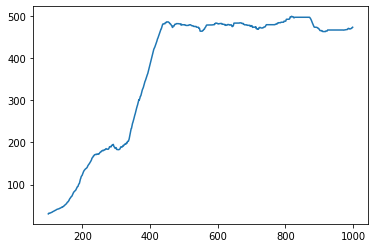

In [86]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward[num_iter]
    buffer_sum -= total_reward[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, max_iter), avg_reward)
plt.show()

### Bonus: Entropy regularized A2C

The exploration-exploition trade-off is also a significant problem to be solved in the context of policy gradients.
There have been numerous approaches in literature aimed towards maximizing exploration in a principled and theoretically meaningful manner.
One such example is the entropy regularised policy gradient objective:
$$
J_\tau(\theta) = J(\theta) + \tau \mathbb{E}_{s \sim d^\pi_s}\left[-\sum_a \pi_\theta(a|s) \log \pi_\theta(a|s)\right],
$$
where $J(\theta)$ is the vanilla policy gradient objective and $\tau$ is a hyperparameter controlling regularisation.

Use entropy regularisation on the CartPole task.
Implement a new loss function that returns your modified loss with entropy regularization.
Also feel free to explore different values of $\tau$ and it's effect on the policy optimization process.

<b style="color:red"> Bonus Question (15 points): </b>
Explain why entropy regularization makes sense for encouraging exploration.
Then modify the training code from above to demonstrate A2C with entropy regularization

*Entropy denotes the uncertainty of a random variable. Under RL settings, entropy refers to the predictability of the actions of an agent. By implementing entropy regularization on the actor policy distribution, we can encourage the randomness when the agent takes an action while maintaining the previously maximized expected return. This will help the algorithm aviod getting stuck in a local optimum because of not exploring the behavior of other actions and never finding the global optimum.*

In [82]:
# TODO: implement entropy regularized A2C and compare your results with the previous model

start_time = time.time()
max_iter = 1000
max_episode_len = 1000
total_reward_with_entropy = []

for num_iter in range(max_iter):
    # at each iteration, we roll out an episode using current policy until it reach termination state or the maximum length
    reward = []
    value_buf = []
    log_p_buf = []
    entropy_buf = []
    
    s = env.reset()
    for t in range(max_episode_len):
        # given current state, the actor outputs two values as probability for each action
        state = torch.tensor(s, dtype=torch.float).view(1, -1)
        prob = actor(state)
        # create the distribution as current policy
        pi = Categorical(prob)
        # sample one action from this policy
        a = pi.sample()
        
        # interact with the environment
        s, r, is_terminal, _ = env.step(a.item())      
        reward.append(r)
        
        # hints: outputs of the actor and critic nets
        value = critic(state)
        value_buf.append(value)
        log_p = pi.log_prob(a)
        log_p_buf.append(log_p)
        entropy_buf.append(pi.entropy())
        
        if is_terminal:
            break
            
    # store total_reward_with_entropy
    total_reward_with_entropy.append(sum(reward))
    
    # for the actor, you can use policy gradient method (with baseline), what is the loss
    # for the critic, you can use Monte-Carlo, TD(0), TD(\lambda), what is the loss
    # also collect entropy
    
    returns = torch.zeros(len(reward) + 1)
    advantage = torch.zeros(len(reward))
    value = torch.cat(value_buf)
    log_p = torch.cat(log_p_buf)
    entropy = torch.cat(entropy_buf)
    
    
    for t in reversed(range(len(reward))):
        returns[t] = reward[t] + gamma * returns[t + 1]
        advantage[t] = returns[t] - value[t]
    
    
    # add entropy regularization
    tau = 0.01
    actor_loss = -(log_p * advantage.detach() + entropy).mean()
    critic_loss = (torch.square(advantage)).mean()
    
    actor_opt.zero_grad()
    critic_opt.zero_grad()
    
    actor_loss.backward()
    critic_loss.backward()
    
    actor_opt.step()
    critic_opt.step()

env.close()
print('Training time: {:.2f}s'.format(time.time() - start_time))

Training time: 456.40s


Successfully solve the problem in 101 iterations with entropy regularization.


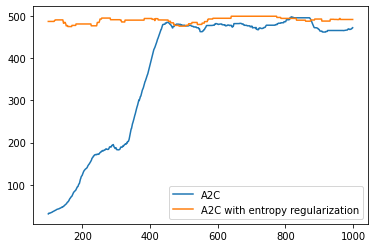

In [87]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward_with_entropy[:buffer_len])
avg_reward_with_entropy = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward_with_entropy[num_iter]
    buffer_sum -= total_reward_with_entropy[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward_with_entropy.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations with entropy regularization.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, max_iter), avg_reward, label="A2C")
plt.plot(range(buffer_len-1, max_iter), avg_reward_with_entropy, label="A2C with entropy regularization")
plt.legend()
plt.show()

### Next Steps

For your own curiosity (you do not need to hand this in, it will not be graded), you can try the following in addition to the exercises:
1. Try other environments in OpenAI Gym. You can do this by simply changing the argument in `env =  gym.make()`. For other environments, see [here](https://gym.openai.com/envs/#classic_control).
2. Implement other RL algorithms and compare with A2C. For example, SARSA, PPO, TRPO, A3C, etc.